**Daily Weather Forecast with the Prophet Time Series Model**

---

In [ ]:
# install and import Dependencies

!pip install pystan
!pip install fbprophet

In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.dates
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# read data from file
# daily weather (meantemp) data from Delhi

df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DailyDelhiClimateTrain.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/DailyDelhiClimateTest.csv')

In [ ]:
# preview the data

df_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
# see the number of rows and columns

df_train.shape, df_test.shape

((1462, 5), (114, 5))

In [ ]:
# check for null values

df_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
df_test.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
# rename the colums 'meantemp' as 'y' and 'date' as 'ds'

df_train = df_train.rename(columns={'meantemp': 'y', 'date':'ds'})
df_test = df_test.rename(columns={'meantemp': 'y', 'date':'ds'})

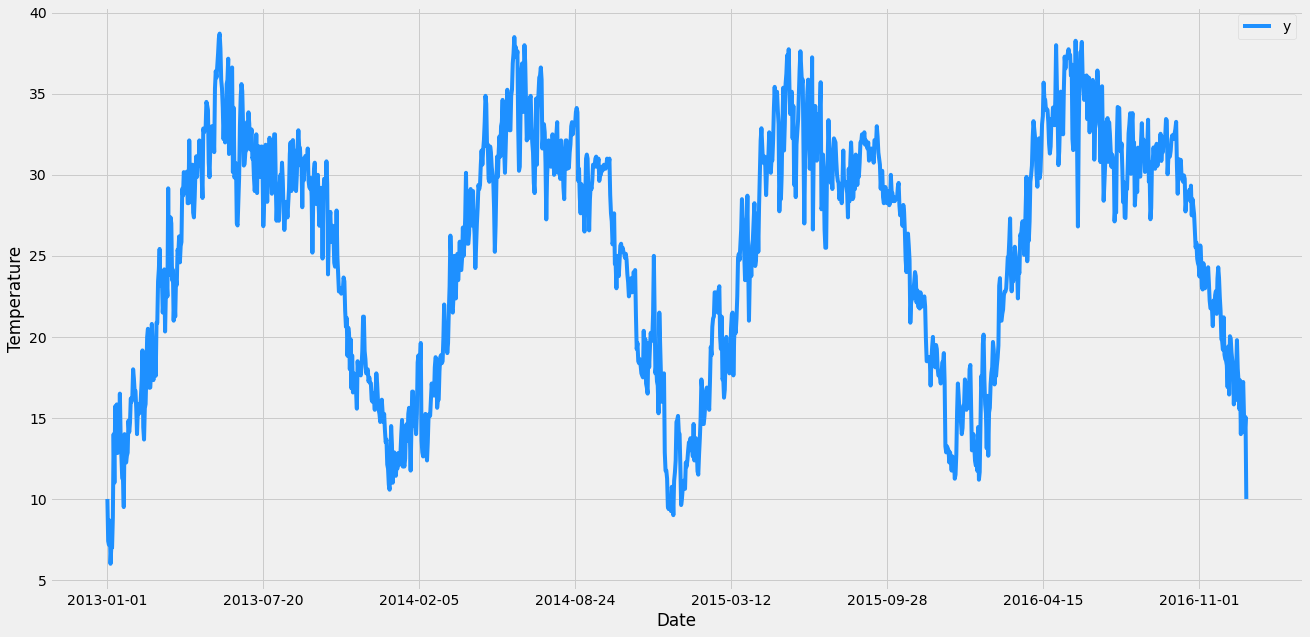

In [ ]:
# visualize the training data

plot1 = df_train.plot(
    kind='line',
    x='ds',
    y='y',
    color='dodgerblue',
    xlabel = 'Date',
    ylabel = 'Temperature',
    figsize=(20,10))

In [ ]:
# instantiate Prophet and fit the model

model = Prophet(interval_width=0.90)
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# forecast future periods

future_data = model.make_future_dataframe(periods=114, freq = 'D')
forecast_data = model.predict(future_data)

In [ ]:
# preview the forecasted data

forecast_data[['ds','yhat_lower', 'yhat', 'yhat_upper']].tail()

,ds,yhat_lower,yhat,yhat_upper
1571,2017-04-21,29.912853,33.042480,36.362746
1572,2017-04-22,30.103710,33.124143,36.547758
1573,2017-04-23,29.784809,33.170758,36.513868
1574,2017-04-24,30.038942,33.521261,36.842040
1575,2017-04-25,30.529038,33.725627,37.183606


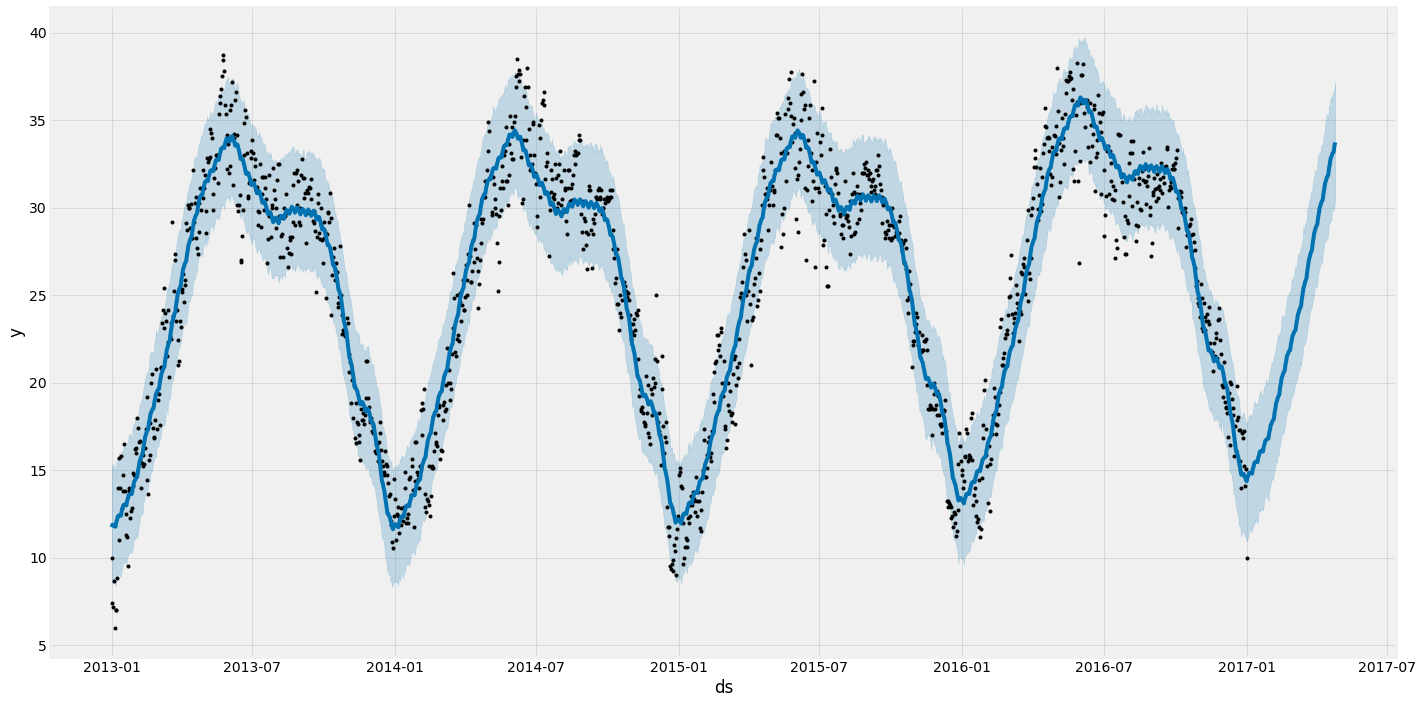

In [ ]:
# visualize the forecast;
# blue line is the prediction ('yhat');
# shaded blue region represents the upper bound ('yhat_upper') and the lowers bound ('yhat_lower') of the forecast;
# black dots are the actual value;

plot2 = model.plot(forecast_data, figsize=(20,10))

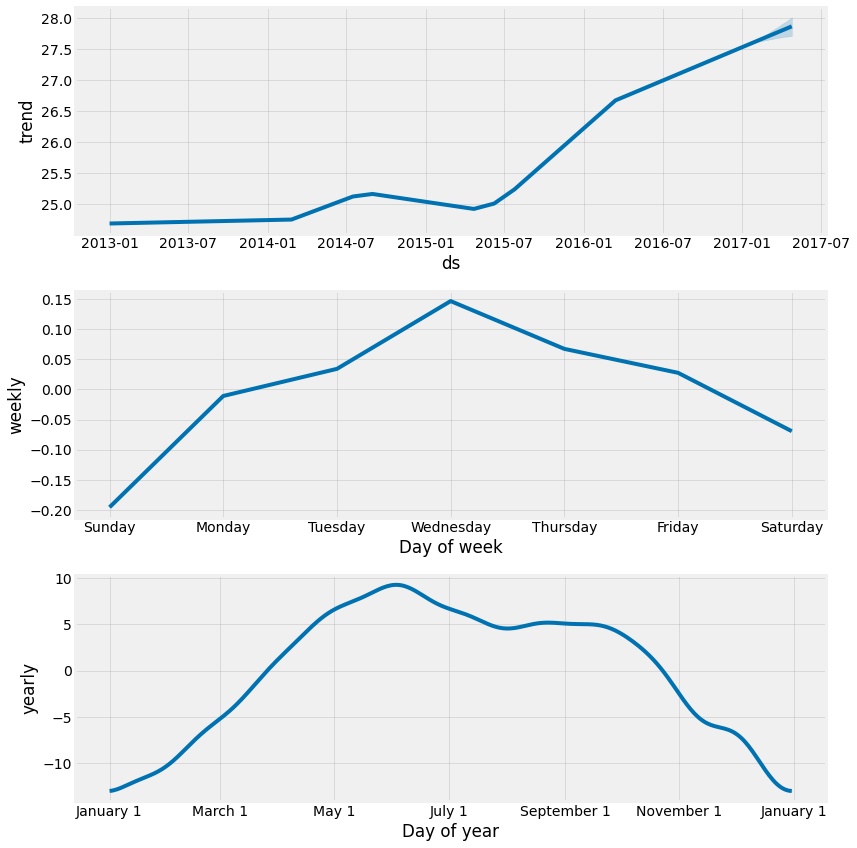

In [ ]:
# decompose the trend

plot3 = model.plot_components(forecast_data, figsize=(12,12))

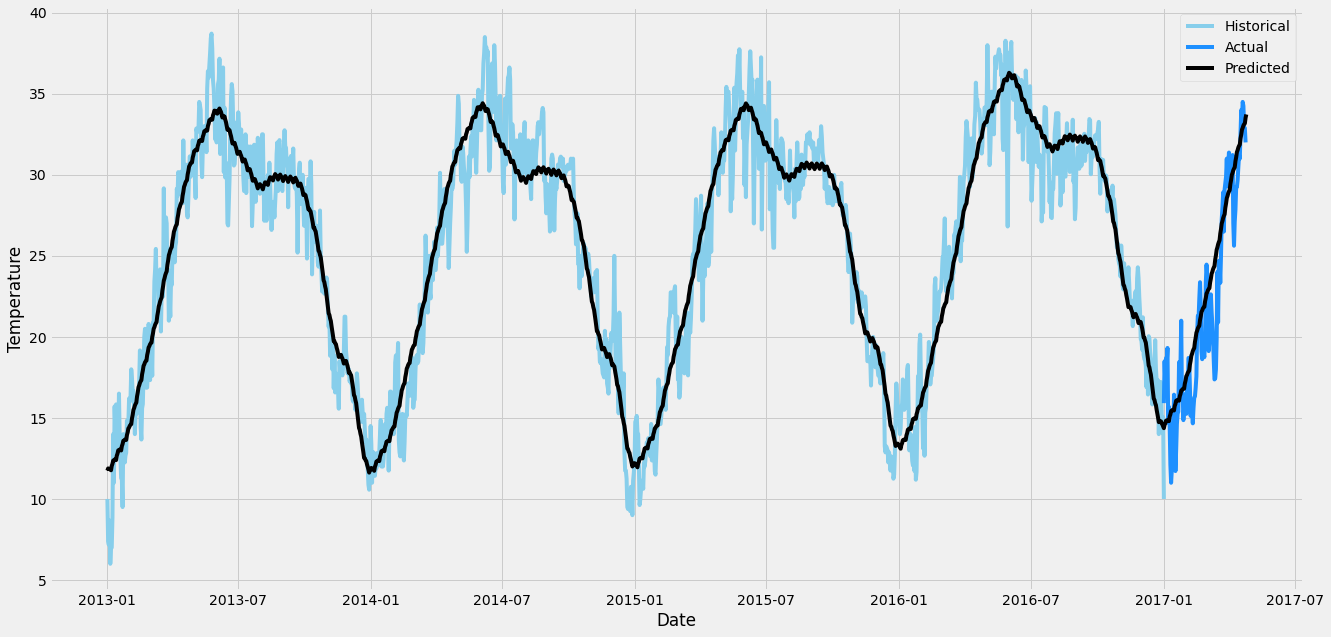

In [ ]:
# re-plot the forecasted data;

fi2, plot4 = plt.subplots(figsize=(20,10))

plot4.plot(pd.to_datetime(df_train['ds']), df_train['y'], label = 'Historical', color='skyblue')
plot4.plot(pd.to_datetime(df_test['ds']), df_test['y'], label = 'Actual', color='dodgerblue')
plot4.plot(pd.to_datetime(forecast_data['ds']), forecast_data['yhat'], label = 'Predicted', color='black')

plot4.set_xlabel('Date')
plot4.set_ylabel('Temperature')

plt.legend()
plt.show()

In [ ]:
# combine train and forecast data

df_train['ds'] = pd.to_datetime(df_train['ds'])


df_train_merged = pd.merge(
    df_train[['ds', 'y']],
    forecast_data[['ds','yhat_lower', 'yhat', 'yhat_upper']].query(" `ds` <= '2017-01-01' "),
    on='ds',
    how='left')

In [ ]:
# combine test and forecast data

df_test['ds'] = pd.to_datetime(df_test['ds'])

df_test_merged = pd.merge(
    df_test[['ds', 'y']],
    forecast_data[['ds','yhat_lower', 'yhat', 'yhat_upper']].query(" `ds` > '2017-01-01' "),
    on='ds',
    how='left')

In [ ]:
# calculating Mean Absolute Error on the forecast for the train data

print('Mean Absolute Error:',
      np.mean(np.abs(df_train_merged['yhat']-df_train_merged['y'])).round(2), '(' + str(np.mean((np.abs(((df_train_merged['yhat']-df_train_merged['y'])/df_train_merged['y']))*100)).round()) + '%)')

Mean Absolute Error: 1.6 (7.0%)


In [ ]:
# calculating Mean Absolute Error on the forecast for the test data

print('Mean Absolute Error:',
      np.mean(np.abs(df_test_merged['yhat']-df_test_merged['y'])).round(2), '(' + str(np.mean((np.abs(((df_test_merged['yhat']-df_test_merged['y'])/df_test_merged['y']))*100)).round()) + '%)')

Mean Absolute Error: 2.2 (12.0%)
